# Inro
**The main goal is to predict the sale price of the property.
A secondary purpose is to find trends in the data that can be used to recommend investment properties.**

References: I have used this notebook for reference -
[Learn Regression @ NYC](https://www.kaggle.com/sahilrider/learn-regression-nyc)

# 1.Loading libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from scipy import stats

In [2]:
#Reading Dataset
df = pd.read_csv('../input/nyc-rolling-sales.csv')

In [3]:
# Little peek into the dataset
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [4]:
#Dropping column as it is empty
del df['EASE-MENT']
#Dropping as it looks like an iterator
del df['Unnamed: 0']



# 2.Data Inspection & Visualization

In [5]:
#shape of dataset
df.shape

(84548, 20)

In [6]:
#Description of every column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
BOROUGH                           84548 non-null int64
NEIGHBORHOOD                      84548 non-null object
BUILDING CLASS CATEGORY           84548 non-null object
TAX CLASS AT PRESENT              84548 non-null object
BLOCK                             84548 non-null int64
LOT                               84548 non-null int64
BUILDING CLASS AT PRESENT         84548 non-null object
ADDRESS                           84548 non-null object
APARTMENT NUMBER                  84548 non-null object
ZIP CODE                          84548 non-null int64
RESIDENTIAL UNITS                 84548 non-null int64
COMMERCIAL UNITS                  84548 non-null int64
TOTAL UNITS                       84548 non-null int64
LAND SQUARE FEET                  84548 non-null object
GROSS SQUARE FEET                 84548 non-null object
YEAR BUILT                        84548 non-null int64
TAX

In [7]:
#Let's convert some of the columns to appropriate datatype

df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['BOROUGH'] = df['BOROUGH'].astype('category')

In [8]:
#delete duplicate values
print(sum(df.duplicated(df.columns)))
df = df.drop_duplicates(df.columns, keep='last')
print(sum(df.duplicated(df.columns)))

765
0


In [9]:
#checking missing values

df.columns[df.isnull().any()]

Index(['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE'], dtype='object')

In [10]:
# Removes all NULL values
df = df[df['SALE PRICE'].notnull()]
#Fill NUll with mean values:
df['LAND SQUARE FEET']=df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET']=df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())
df.columns[df.isnull().any()]

Index([], dtype='object')

In [11]:
df.shape

(69607, 20)

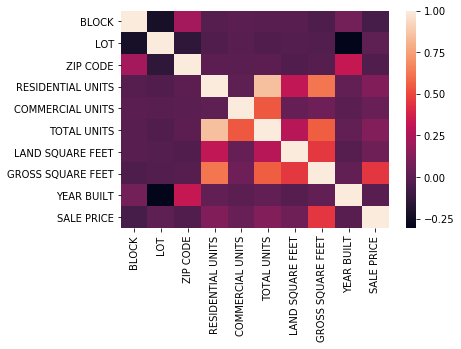

In [12]:
#correlation between the features
corr = df.corr()
sns.heatmap(corr)

Last row represents the correlation of different features with SALE PRICE

In [13]:
#numeric correlation
corr['SALE PRICE'].sort_values(ascending=False)

SALE PRICE           1.000000
GROSS SQUARE FEET    0.449540
TOTAL UNITS          0.126576
RESIDENTIAL UNITS    0.122465
LAND SQUARE FEET     0.060074
COMMERCIAL UNITS     0.044534
LOT                  0.012319
YEAR BUILT          -0.003708
ZIP CODE            -0.034152
BLOCK               -0.061249
Name: SALE PRICE, dtype: float64


**SALE PRICE**

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


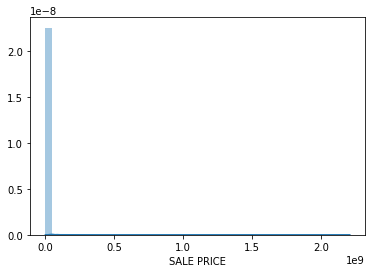

In [14]:
sns.distplot(df['SALE PRICE'])

In [15]:
# Remove observations that fall outside those caps
df = df[(df['SALE PRICE'] > 100000) & (df['SALE PRICE'] < 5000000)]

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


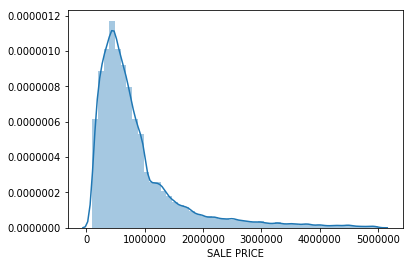

In [16]:
sns.distplot(df['SALE PRICE'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


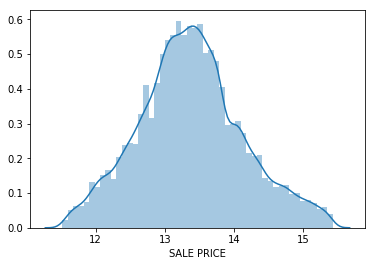

In [17]:
sales=np.log(df['SALE PRICE'])

sns.distplot(sales)

**Data visualization**

Preset the difference between commercial units to residential unit over the years

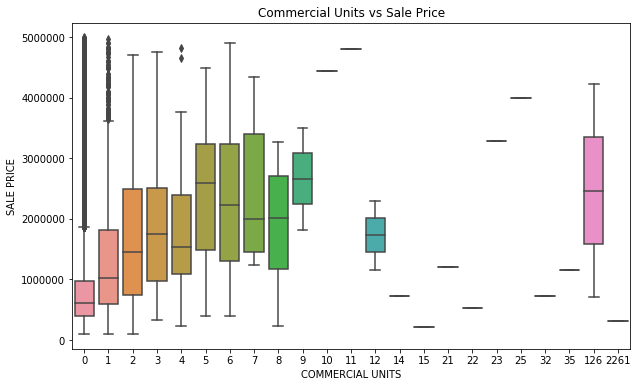

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(x='COMMERCIAL UNITS', y='SALE PRICE', data=df)
plt.title('Commercial Units vs Sale Price')
plt.show()

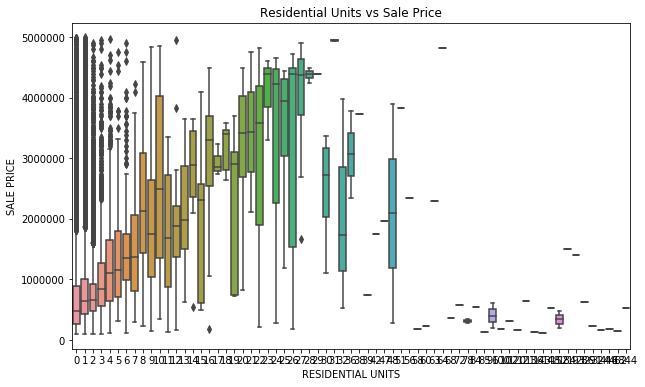

In [19]:
plt.figure(figsize=(10,6))
sns.boxplot(x='RESIDENTIAL UNITS', y='SALE PRICE', data=df)
plt.title('Residential Units vs Sale Price')
plt.show()

**Lets compare between commartial to residential **

I'm assume that buliding with more residential units is a residetial, and the opesite

In [20]:
df["COM_OR_RES"]=df["RESIDENTIAL UNITS"] <= df["COMMERCIAL UNITS"]

In [21]:
#change the type of COM_OR_RES, 1 means its COM and 0 its RES
df.COM_OR_RES = df.COM_OR_RES.astype(int)

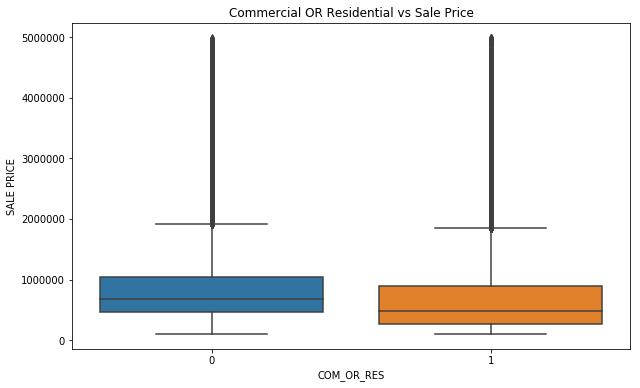

In [22]:
plt.figure(figsize=(10,6))
sns.boxplot(x='COM_OR_RES', y='SALE PRICE', data=df)
plt.title('Commercial OR Residential vs Sale Price')
plt.show()

As we can see in the chart, the residential proparteis are more expensive then commercial,
but we neet to check if it true, becuase maybe the residetal building are bigger.

I start with visualizing the "GROSS SQUARE FEET":

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 720x432 with 0 Axes>

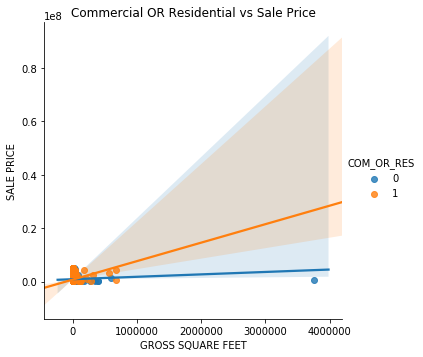

In [23]:
plt.figure(figsize=(10,6))
sns.lmplot(x="GROSS SQUARE FEET", y="SALE PRICE", hue="COM_OR_RES",
               height=5, data=df)
plt.title('Commercial OR Residential vs Sale Price')
plt.show()

In [24]:
#Remove some outlayers
df = df[df['GROSS SQUARE FEET'] < 10000]


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 720x432 with 0 Axes>

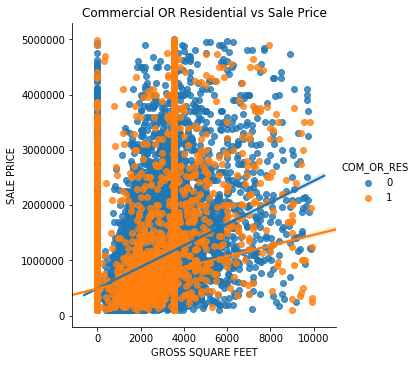

In [25]:
plt.figure(figsize=(10,6))
sns.lmplot(x="GROSS SQUARE FEET", y="SALE PRICE", hue="COM_OR_RES",
               height=5, data=df)
plt.title('Commercial OR Residential vs Sale Price')
plt.show()

I want to check what is the price per feet and then i will understand which type is more expensive per feet.

In [26]:
df["PRICE/GROSS"]=df["SALE PRICE"]/df["GROSS SQUARE FEET"]

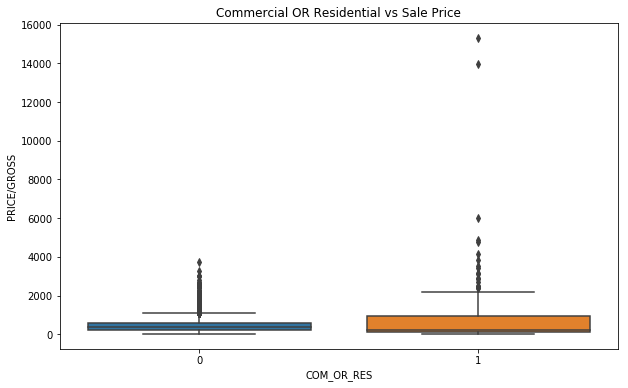

In [27]:
plt.figure(figsize=(10,6))
sns.boxplot(x='COM_OR_RES', y='PRICE/GROSS', data=df)
plt.title('Commercial OR Residential vs Sale Price')
plt.show()

**So, we can see that the sell price per one feet of the commercial are highers than residential in the overall**

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54275 entries, 3 to 84545
Data columns (total 22 columns):
BOROUGH                           54275 non-null category
NEIGHBORHOOD                      54275 non-null object
BUILDING CLASS CATEGORY           54275 non-null object
TAX CLASS AT PRESENT              54275 non-null category
BLOCK                             54275 non-null int64
LOT                               54275 non-null int64
BUILDING CLASS AT PRESENT         54275 non-null object
ADDRESS                           54275 non-null object
APARTMENT NUMBER                  54275 non-null object
ZIP CODE                          54275 non-null int64
RESIDENTIAL UNITS                 54275 non-null int64
COMMERCIAL UNITS                  54275 non-null int64
TOTAL UNITS                       54275 non-null int64
LAND SQUARE FEET                  54275 non-null float64
GROSS SQUARE FEET                 54275 non-null float64
YEAR BUILT                        54275 non-null in

**Next step, try to find trends in the Sale Price**

In [29]:
#There are duplicates value in SALE DATE so i transform it to integer
df['DATE_DELTA'] = (df['SALE DATE'] - df['SALE DATE'].min())  / np.timedelta64(1,'D')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


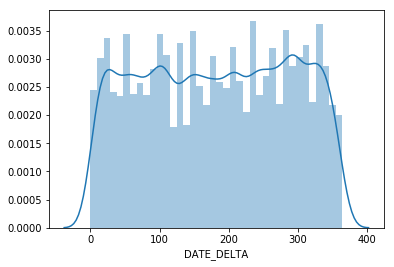

In [30]:
sns.distplot(df['DATE_DELTA'])

As we can see in the chart, all of the year (2016) there are transactions 

In [31]:
#Explorer the data only in Manhattan
dataPlot=df[df["BOROUGH"]==1]

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 720x432 with 0 Axes>

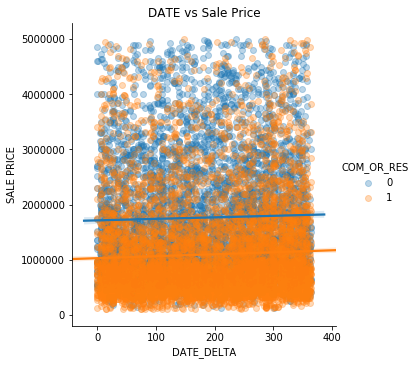

In [32]:

plt.figure(figsize=(10,6))
sns.lmplot(x='DATE_DELTA', y='SALE PRICE', data=dataPlot, fit_reg=True, scatter_kws={'alpha':0.3} ,hue="COM_OR_RES")
plt.title('DATE vs Sale Price')
plt.show()

**Now I'll try to find trends base on Neighborhood **

In [33]:
#change the type of the feature to category
df['NEIGHBORHOOD'] = df['NEIGHBORHOOD'].astype('category')

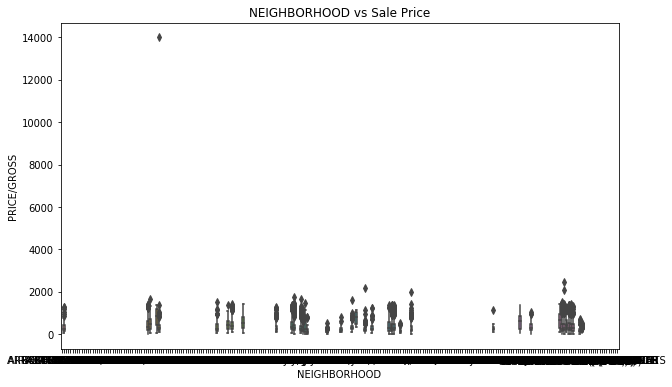

In [34]:
plt.figure(figsize=(10,6))
sns.boxplot(x='NEIGHBORHOOD', y='PRICE/GROSS', data=df[df["BOROUGH"]==1])
plt.title('NEIGHBORHOOD vs Sale Price')
plt.show()

In [35]:
#droping outlayers
df=df[df['PRICE/GROSS'] < 5000]

In the next steps I'll find the most interesting Neighborhood and chack trends in them.

In [36]:
#group by NEIGHBORHOOD how many sales occuer in one year
High=df[["NEIGHBORHOOD", "SALE PRICE"]].groupby(['NEIGHBORHOOD'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

In [37]:
#extrat the name of NEIGHBORHOOD with above 400 sales
List=High.NEIGHBORHOOD[High["SALE PRICE"]>= 400]

In [38]:
#new data only with interesting NEIGHBORHOOD
data_High_val=df.loc[df['NEIGHBORHOOD'].isin(List)]

Lets plot again after the changes

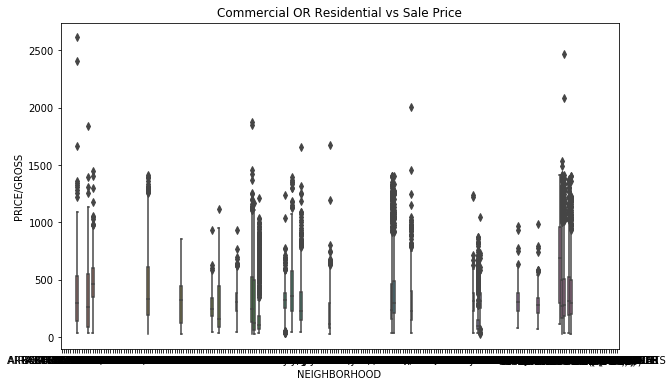

In [39]:

plt.figure(figsize=(10,6))
sns.boxplot(x='NEIGHBORHOOD', y='PRICE/GROSS', data=data_High_val)
plt.title('Commercial OR Residential vs Sale Price')
plt.show()

In [40]:
data_High_val.shape

(18759, 23)

In [41]:
#remove unused categories
data_High_val.NEIGHBORHOOD=data_High_val.NEIGHBORHOOD.cat.remove_unused_categories()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


**Plot the Sale Price and the Date by NEIGHBORHOOD categories and find if the price of some NEIGHBORHOOD are increased.**

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 2880x432 with 0 Axes>

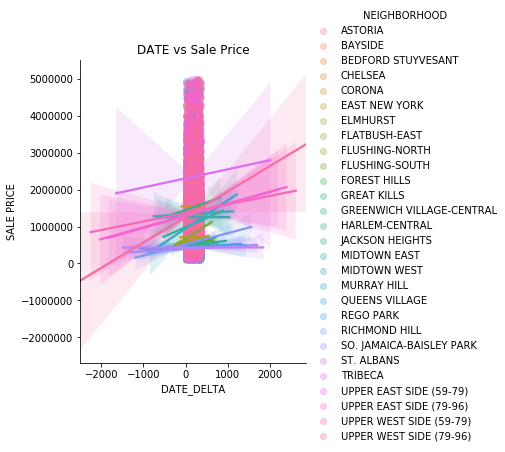

In [42]:
plt.figure(figsize=(40,6))
sns.lmplot(x='DATE_DELTA', y='SALE PRICE', data=data_High_val, fit_reg=True, scatter_kws={'alpha':0.3} ,hue="NEIGHBORHOOD")
plt.title('DATE vs Sale Price')
plt.show()

**As we can see there are some NEIGHBORHOOD with increasing in the price over the year**
its looks like it worth deepdiving in this area

# 3. Data Pre Processing

In [43]:
data=df

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46312 entries, 3 to 84545
Data columns (total 23 columns):
BOROUGH                           46312 non-null category
NEIGHBORHOOD                      46312 non-null category
BUILDING CLASS CATEGORY           46312 non-null object
TAX CLASS AT PRESENT              46312 non-null category
BLOCK                             46312 non-null int64
LOT                               46312 non-null int64
BUILDING CLASS AT PRESENT         46312 non-null object
ADDRESS                           46312 non-null object
APARTMENT NUMBER                  46312 non-null object
ZIP CODE                          46312 non-null int64
RESIDENTIAL UNITS                 46312 non-null int64
COMMERCIAL UNITS                  46312 non-null int64
TOTAL UNITS                       46312 non-null int64
LAND SQUARE FEET                  46312 non-null float64
GROSS SQUARE FEET                 46312 non-null float64
YEAR BUILT                        46312 non-null 

In [45]:
#Dropping few columns
del data["SALE DATE"]
del data["PRICE/GROSS"]
del data['BUILDING CLASS AT PRESENT']
del data['BUILDING CLASS AT TIME OF SALE']
del data['NEIGHBORHOOD']
del data['ADDRESS']
del data['APARTMENT NUMBER']


**One hot encoding categorical columns**

In [46]:
#Select the variables to be one-hot encoded
one_hot_features = ['BOROUGH', 'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE']


In [47]:
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(df[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46312 entries, 3 to 84545
Data columns (total 59 columns):
BOROUGH_1                                                               46312 non-null uint8
BOROUGH_2                                                               46312 non-null uint8
BOROUGH_3                                                               46312 non-null uint8
BOROUGH_4                                                               46312 non-null uint8
BOROUGH_5                                                               46312 non-null uint8
BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                         46312 non-null uint8
BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS                         46312 non-null uint8
BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS                       46312 non-null uint8
BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS                           46312 non-null uint8
BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND    

In [48]:
# Replacing categorical columns with dummies
fdf = df.drop(one_hot_features,axis=1)
fdf = pd.concat([fdf, one_hot_encoded] ,axis=1)

In [49]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46312 entries, 3 to 84545
Data columns (total 71 columns):
BLOCK                                                                   46312 non-null int64
LOT                                                                     46312 non-null int64
ZIP CODE                                                                46312 non-null int64
RESIDENTIAL UNITS                                                       46312 non-null int64
COMMERCIAL UNITS                                                        46312 non-null int64
TOTAL UNITS                                                             46312 non-null int64
LAND SQUARE FEET                                                        46312 non-null float64
GROSS SQUARE FEET                                                       46312 non-null float64
YEAR BUILT                                                              46312 non-null int64
SALE PRICE                                        

## Train/Test Split

In [50]:

Y_fdf = np.log(fdf['SALE PRICE'])
X_fdf = fdf.drop('SALE PRICE', axis=1)

X_fdf.shape , Y_fdf.shape

((46312, 70), (46312,))

In [51]:
X_train ,X_test, Y_train , Y_test = train_test_split(X_fdf , Y_fdf , test_size = 0.3 , random_state =34)

In [52]:
# Training set
X_train.shape , Y_train.shape

((32418, 70), (32418,))

In [53]:
#Testing set
X_test.shape , Y_test.shape

((13894, 70), (13894,))

# 4. Modelling

In [54]:
# RMSE
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

### 4.1 Linear Regression

In [55]:
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
Y_pred_lin = linreg.predict(X_test)
rmse(Y_test,Y_pred_lin)

0.5113523766042405

## [](http://) 4.2. RandomForest Regressor

In [56]:
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, Y_train)
Y_pred_rf = rf_regr.predict(X_test)
rmse(Y_test,Y_pred_rf)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.42533661056636163

# [](http://) 4.3. GradientBoosting Regressor

In [57]:
gbm = GradientBoostingRegressor(learning_rate = 0.1,
                                random_state = 1234)
gbm.fit(X_train, Y_train)
Y_pred_rf = gbm.predict(X_test)
rmse(Y_test,Y_pred_rf)

0.46330872685032576

# 5. Conclusion

**We can see that Random Forest Regressor works best for this dataset with RSME score of 0.42**